# Diagnóstico de doença de plantas baseado em imagens

Baseado nos artigos:

* "Image-based Plant Disease Diagnosis with Unsupervised Anomaly"
de Ryoya Katafuchi e Terumasa Tokunaga1Y - Disponível em https://arxiv.org/pdf/2011.14306

Estrutura baseada no código disponibilizado pelo monitor da disciplina em https://github.com/gfrep/DeteccaoAnomalia.

## 1. Preparação

Instalando dependências

In [73]:
!pip install -q -U gdown dominate visdom "pillow>=10,<12" scikit-image scikit-learn

import csv
import os
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image, ImageOps
from skimage.color import deltaE_ciede2000, rgb2lab
from sklearn.metrics import roc_auc_score

Clonando CycleGAN and pix2pix in PyTorch

In [4]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd /content/pytorch-CycleGAN-and-pix2pix

!python train.py -h | head -n 25
!python test.py -h | head -n 35

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2619, done.
remote: Total 2619 (delta 0), reused 0 (delta 0), pack-reused 2619 (from 1)
Receiving objects: 100% (2619/2619), 8.23 MiB | 28.20 MiB/s, done.
Resolving deltas: 100% (1654/1654), done.
/content/pytorch-CycleGAN-and-pix2pix
usage: train.py [-h] --dataroot DATAROOT [--name NAME]
                [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL]
                [--input_nc INPUT_NC] [--output_nc OUTPUT_NC] [--ngf NGF]
                [--ndf NDF] [--netD NETD] [--netG NETG]
                [--n_layers_D N_LAYERS_D] [--norm NORM]
                [--init_type INIT_TYPE] [--init_gain INIT_GAIN] [--no_dropout]
                [--dataset_mode DATASET_MODE] [--direction DIRECTION]
                [--serial_batches] [--num_threads NUM_THREADS]
                [--batch_size BATCH_SIZE] [--load_size LOAD_SIZE]
                [--crop_size CROP_SIZE] [--max_dataset_size MAX_DATASET_SIZE]
                [--prepr

Criando diretório base para as imagens fornecidas pelo professor

In [5]:
!mkdir -p /content/data
DATASET_ZIP_URL = "https://drive.google.com/file/d/1LozY0bo07CtKWy7Liz8MUnfONuCaF3IA/view?usp=drive_link"
OUT_ZIP = "/content/data/dataset.zip"
if "COLE_AQUI" not in DATASET_ZIP_URL:
    !gdown --fuzzy "{DATASET_ZIP_URL}" -O "{OUT_ZIP}"
!ls -lah /content/data
!unzip -q -o "{OUT_ZIP}" -d /content/data || true
!find /content/data -maxdepth 4 -type d -name "Projeto_Ramularia" -print

Downloading...
From (original): https://drive.google.com/uc?id=1LozY0bo07CtKWy7Liz8MUnfONuCaF3IA
From (redirected): https://drive.google.com/uc?id=1LozY0bo07CtKWy7Liz8MUnfONuCaF3IA&confirm=t&uuid=89e630eb-3d70-42a2-be62-3379a8aaa681
To: /content/data/dataset.zip
100% 55.1M/55.1M [00:01<00:00, 40.7MB/s]
total 53M
drwxr-xr-x 2 root root 4.0K Dec  7 15:08 .
drwxr-xr-x 1 root root 4.0K Dec  7 15:08 ..
-rw-r--r-- 1 root root  53M Dec  4 11:27 dataset.zip
/content/data/Projeto_Ramularia


Identificando os diretórios do dataset de imagens


In [6]:
BASE = Path("/content/data/Projeto_Ramularia")
print(f"Diretório base: {BASE}")

for dname in ["Healthy_Train50", "Healthy_Test50", "Disease_Test100"]:
  d = BASE / dname
  print(f"\nDiretório {dname}: {d}")
  n = len(list(d.glob("*.jpg")) + list(d.glob("*.png"))) if d.exists() else 0
  print(f"{dname} / Número de imagens: {n}" if d.exists() else f"{dname} / Diretório não existe")

Diretório base: /content/data/Projeto_Ramularia

Diretório Healthy_Train50: /content/data/Projeto_Ramularia/Healthy_Train50
Healthy_Train50 / Número de imagens: 50

Diretório Healthy_Test50: /content/data/Projeto_Ramularia/Healthy_Test50
Healthy_Test50 / Número de imagens: 50

Diretório Disease_Test100: /content/data/Projeto_Ramularia/Disease_Test100
Disease_Test100 / Número de imagens: 100


Configuração de Caminhos e Diretórios


In [7]:
SRC = Path("/content/data/Projeto_Ramularia")
HEALTHY_TRAIN = SRC / "Healthy_Train50"
HEALTHY_TEST  = SRC / "Healthy_Test50"
DISEASE_TEST  = SRC / "Disease_Test100"


OUT = Path("/content/data/ramularia_colorrec")
AB_TRAIN = OUT / "AB" / "train"
AB_TEST  = OUT / "AB" / "test"
AB_TRAIN.mkdir(parents=True, exist_ok=True)
AB_TEST.mkdir(parents=True, exist_ok=True)

In [8]:
MANIFEST = OUT / "manifesto_do_teste.csv"

In [9]:
IMG_SIZE = (256,256)

Pega a imagem colorida, redimensiona, converte uma cópia para escala de cinza (canal 'A') e mantém a versão colorida (canal 'B').
Em seguida, ela concatena essas duas imagens horizontalmente para criar um par 'AB' (escala de cinza ao lado da colorida).

In [10]:
def cria_par_ab(color_img: Image.Image) -> Image.Image:
    B = color_img.convert("RGB").resize(IMG_SIZE, Image.BICUBIC)
    A = B.convert("L").convert("RGB")
    AB = Image.new("RGB", (IMG_SIZE[0] * 2, IMG_SIZE[1]))
    AB.paste(A, (0, 0))
    AB.paste(B, (IMG_SIZE[0], 0))
    return AB

Percorre um diretório e retorna uma lista ordenada de todos os arquivos de imagem (jpg, jpeg, png) encontrados.

In [11]:
def lista_imagens(folder: Path):
    exts = ["*.jpg", "*.jpeg", "*.png"]
    files = []
    for e in exts:
        files += list(folder.glob(e))
    return sorted(files)

Pega cada imagem, a converte para o formato 'AB' necessário e a salva no diretório de saída de treino.

In [12]:
arquivos_treino = lista_imagens(HEALTHY_TRAIN)
for p in arquivos_treino:
    img = Image.open(p)
    ab = cria_par_ab(img)
    ab.save(AB_TRAIN / (p.stem + ".jpg"), quality=95)

In [13]:
testando_saudaveis = lista_imagens(HEALTHY_TEST)
testando_doentes = lista_imagens(DISEASE_TEST)
treinando_saudaveis = lista_imagens(HEALTHY_TRAIN)

print("Treino saudáveis:", len(treinando_saudaveis))
print("Teste saudáveis:", len(testando_saudaveis))
print("Teste doentes:", len(testando_doentes))

Treino saudáveis: 50
Teste saudáveis: 50
Teste doentes: 100


Rodando testes

In [14]:
rows = []
def adiciona_teste(files, label, prefix):
    for p in files:
        img = Image.open(p)
        ab = cria_par_ab(img)
        out_name = f"{prefix}_{p.stem}.jpg"
        ab.save(AB_TEST / out_name, quality=95)
        rows.append({"file": out_name, "label": label, "src": str(p)})

adiciona_teste(testando_saudaveis, 0, "H")  # 0 = saudável
adiciona_teste(testando_doentes, 1, "D")  # 1 = doente

Incluindo resultados no manifesto

In [15]:
MANIFEST.parent.mkdir(parents=True, exist_ok=True)
with open(MANIFEST, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["file", "label", "src"])
    w.writeheader()
    w.writerows(rows)

In [16]:
print("AB/treino:", len(list(AB_TRAIN.glob("*.jpg"))))
print("AB/teste", len(list(AB_TEST.glob("*.jpg"))))
print("Manifesto:", MANIFEST)

AB/treino: 50
AB/teste 150
Manifesto: /content/data/ramularia_colorrec/manifesto_do_teste.csv


## 2. Treinamento

Executando o treinamento do modelo CycleGAN/pix2pix para a tarefa de tradução de imagem - algoritmo pix2pix.

In [25]:
%cd /content/pytorch-CycleGAN-and-pix2pix

!CUDA_VISIBLE_DEVICES=0 python train.py \
  --dataroot /content/data/ramularia_colorrec/AB \
  --name ramularia_colorrec_pix2pix \
  --model pix2pix \
  --dataset_mode aligned \
  --direction AtoB \
  --netG unet_256 \
  --input_nc 3 --output_nc 3 \
  --load_size 286 --crop_size 256 \
  --batch_size 1 \
  --n_epochs 50 --n_epochs_decay 50 \
  --no_html

/content/pytorch-CycleGAN-and-pix2pix
----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/data/ramularia_colorrec/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
             display_freq: 400                           
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: vanilla                       
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3 

## 3. Reconstrução de cor

Testando o modelo treinado

In [26]:
!CUDA_VISIBLE_DEVICES=0 python test.py \
  --dataroot /content/data/ramularia_colorrec/AB \
  --name ramularia_colorrec_pix2pix \
  --model pix2pix \
  --dataset_mode aligned \
  --direction AtoB \
  --netG unet_256 \
  --epoch latest

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/data/ramularia_colorrec/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
                load_size: 256        

Configurando e identificando locais onde os resultados serão salvos

In [27]:
DIRETORIO_RESULTADOS = Path("/content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images")
MANIFEST = Path("/content/data/ramularia_colorrec/manifesto_do_teste.csv")

print("Já existe DIRETORIO_RESULTADOS?", DIRETORIO_RESULTADOS.exists())
print("Já existe MANIFESTO?", MANIFEST.exists())

df = pd.read_csv(MANIFEST)

Já existe DIRETORIO_RESULTADOS? True
Já existe MANIFESTO? True


In [28]:
def load_rgb(path: Path) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    arr = np.asarray(img).astype(np.float32) / 255.0
    return arr

scores = []
missing = 0

## 4. Calculando os scores de anomalia

Calcula Ciede2000 utilizando a função `deltaE_ciede2000()` da biblioteca  scikit-image.

Calcula a soma do score e a média do score.

In [29]:
for _, row in df.iterrows():
    base = Path(row["file"]).stem
    real_b = DIRETORIO_RESULTADOS / f"{base}_real_B.png"
    fake_b = DIRETORIO_RESULTADOS / f"{base}_fake_B.png"
    if not real_b.exists() or not fake_b.exists():
        missing += 1
        continue

    rb = load_rgb(real_b)
    fb = load_rgb(fake_b)

    lab_rb = rgb2lab(rb)
    lab_fb = rgb2lab(fb)
    de = deltaE_ciede2000(lab_rb, lab_fb)

    score_sum = float(np.sum(de))
    score_mean = float(np.mean(de))

    scores.append((row["file"], int(row["label"]), score_sum, score_mean))

print("Arquivos faltando no results:", missing)

out = pd.DataFrame(scores, columns=["file", "label", "score_sum", "score_mean"])
out = out.merge(df, on=["file", "label"], how="left")

if out["label"].nunique() == 2 and len(out) > 1:
    auc = roc_auc_score(out["label"], out["score_sum"])
    print("AUC (score_sum):", auc)

out = out.sort_values("score_sum", ascending=False)
out.head(15)

Arquivos faltando no results: 100


file  label      score_sum  score_mean  \
39  D_a1017-1020 ad_1.jpg      1  246028.078125    3.754091   
26  D_a1008-1013 ad_4.jpg      1  193531.156250    2.953051   
11  D_a1004-1007 ad_0.jpg      1  180552.609375    2.755014   
22  D_a1008-1013 ad_0.jpg      1  172616.359375    2.633917   
33  D_a1014-1016 ad_2.jpg      1  167509.406250    2.555991   
14  D_a1004-1007 ad_3.jpg      1  167429.937500    2.554778   
3   D_a1001-1003 ad_0.jpg      1  166156.500000    2.535347   
40  D_a1017-1020 ad_2.jpg      1  140081.109375    2.137468   
4   D_a1001-1003 ad_1.jpg      1  131318.015625    2.003754   
5   D_a1001-1003 ad_2.jpg      1  125533.000000    1.915482   
38  D_a1017-1020 ad_0.jpg      1  124601.546875    1.901269   
32  D_a1014-1016 ad_1.jpg      1  123978.304688    1.891759   
46  D_a1021-1023 ad_1.jpg      1  120386.250000    1.836948   
34  D_a1017-1020 ab_0.jpg      1  119789.242188    1.827839   
25  D_a1008-1013 ad_3.jpg      1  117672.820312    1.795545   

                                                  src  
39  /content/data/Projeto_Ramularia/Disease_Test10...  
26  /content/data/Projeto_Ramularia/Disease_Test10...  
11  /content/data/Projeto_Ramularia/Disease_Test10...  
22  /content/data/Projeto_Ramularia/Disease_Test10...  
33  /content/data/Projeto_Ramularia/Disease_Test10...  
14  /content/data/Projeto_Ramularia/Disease_Test10...  
3   /content/data/Projeto_Ramularia/Disease_Test10...  
40  /content/data/Projeto_Ramularia/Disease_Test10...  
4   /content/data/Projeto_Ramularia/Disease_Test10...  
5   /content/data/Projeto_Ramularia/Disease_Test10...  
38  /content/data/Projeto_Ramularia/Disease_Test10...  
32  /content/data/Projeto_Ramularia/Disease_Test10...  
46  /content/data/Projeto_Ramularia/Disease_Test10...  
34  /content/data/Projeto_Ramularia/Disease_Test10...  
25  /content/data/Projeto_Ramularia/Disease_Test10...

In [30]:
!ls -1 /content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images | wc -l
!ls -1 /content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images | head -n 30
!python test.py -h | sed -n '1,120p'


150
D_a1001-1003 ab_0_fake_B.png
D_a1001-1003 ab_0_real_A.png
D_a1001-1003 ab_0_real_B.png
D_a1001-1003 ab_1_fake_B.png
D_a1001-1003 ab_1_real_A.png
D_a1001-1003 ab_1_real_B.png
D_a1001-1003 ab_2_fake_B.png
D_a1001-1003 ab_2_real_A.png
D_a1001-1003 ab_2_real_B.png
D_a1001-1003 ad_0_fake_B.png
D_a1001-1003 ad_0_real_A.png
D_a1001-1003 ad_0_real_B.png
D_a1001-1003 ad_1_fake_B.png
D_a1001-1003 ad_1_real_A.png
D_a1001-1003 ad_1_real_B.png
D_a1001-1003 ad_2_fake_B.png
D_a1001-1003 ad_2_real_A.png
D_a1001-1003 ad_2_real_B.png
D_a1004-1007 ab_0_fake_B.png
D_a1004-1007 ab_0_real_A.png
D_a1004-1007 ab_0_real_B.png
D_a1004-1007 ab_1_fake_B.png
D_a1004-1007 ab_1_real_A.png
D_a1004-1007 ab_1_real_B.png
D_a1004-1007 ab_2_fake_B.png
D_a1004-1007 ab_2_real_A.png
D_a1004-1007 ab_2_real_B.png
D_a1004-1007 ab_3_fake_B.png
D_a1004-1007 ab_3_real_A.png
D_a1004-1007 ab_3_real_B.png
usage: test.py [-h] --dataroot DATAROOT [--name NAME]
               [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL]
     

In [139]:
from PIL import Image as PILImage # Re-import local para evitar conflitos

def load_rgb_uint8(path: Path):
    return np.asarray(PILImage.open(path).convert("RGB"))

Função `show_case` é utilizada para visualizar os resultados da reconstrução de cores e a detecção de anomalias.

Na função é calculado o deltaE_ciede2000 entre a imagem original e a reconstruída.

Esse valor é normalizado e exibido em um mapa de calor.

Reconstruções disponíveis: 50


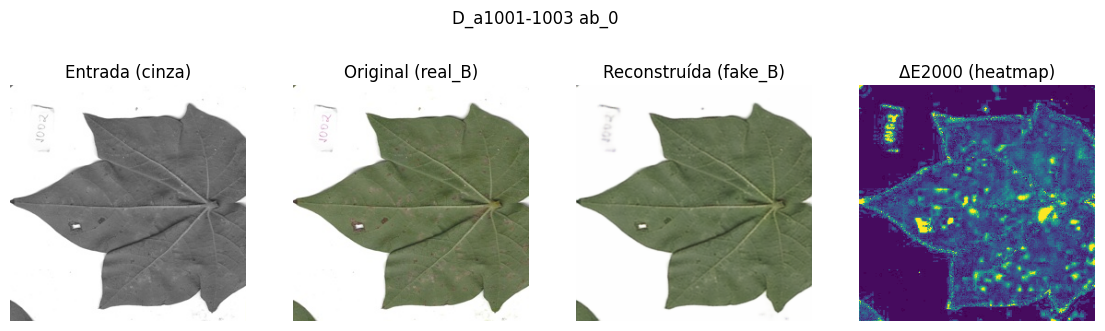

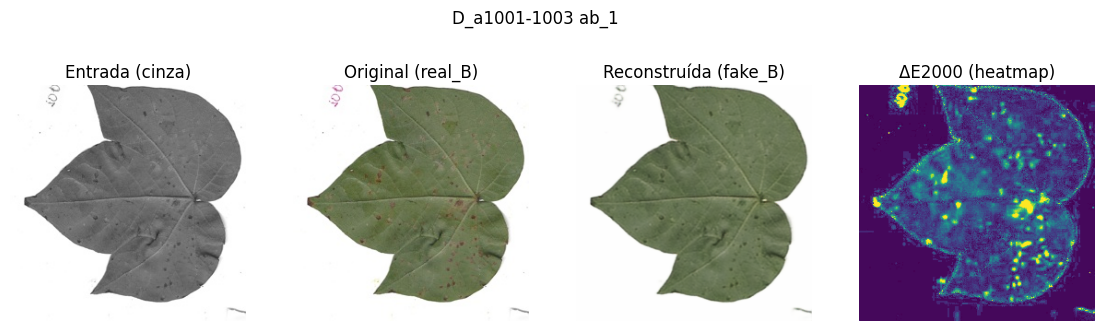

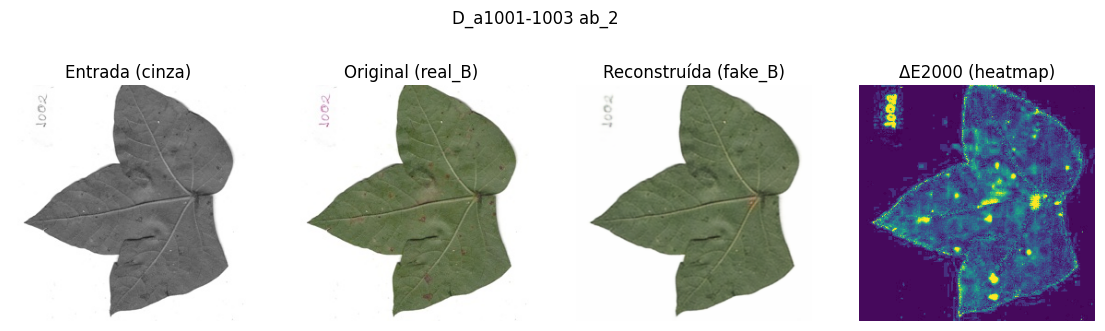

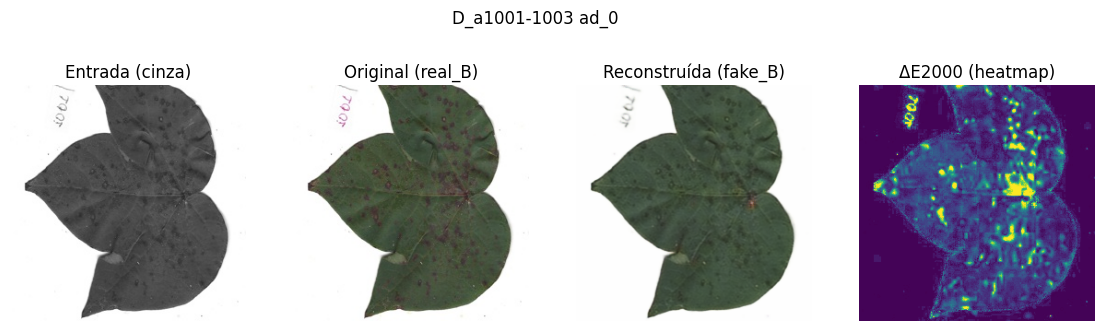

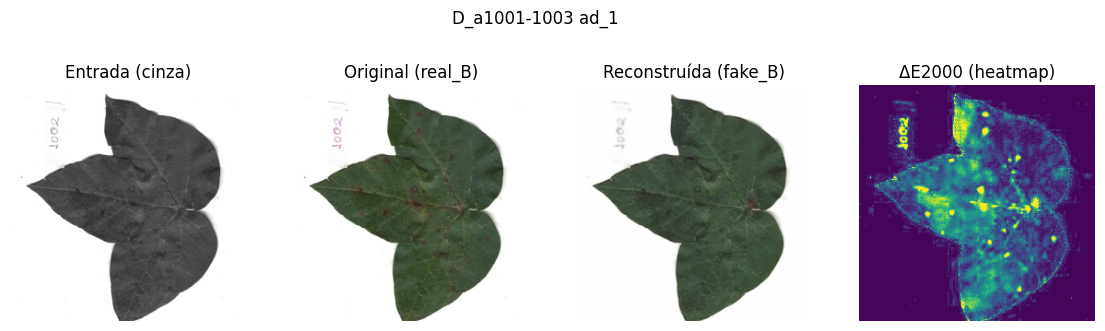

In [140]:
def show_case(base: str, title: str = ""):
    real_b = DIRETORIO_RESULTADOS / f"{base}_real_B.png"
    fake_b = DIRETORIO_RESULTADOS / f"{base}_fake_B.png"
    real_a = DIRETORIO_RESULTADOS / f"{base}_real_A.png"
    if not real_b.exists() or not fake_b.exists():
        print("Não achei:", base)
        return

    rb_u8 = load_rgb_uint8(real_b)
    fb_u8 = load_rgb_uint8(fake_b)
    ra_u8 = load_rgb_uint8(real_a) if real_a.exists() else None

    rb = rb_u8.astype(np.float32) / 255.0
    fb = fb_u8.astype(np.float32) / 255.0
    de = deltaE_ciede2000(rgb2lab(rb), rgb2lab(fb))


    de_norm = de / (np.percentile(de, 99) + 1e-6)
    de_norm = np.clip(de_norm, 0, 1)

    plt.figure(figsize=(14,4))
    if title:
        plt.suptitle(title)

    ax1 = plt.subplot(1,4,1)
    plt.title("Entrada (cinza)")
    if ra_u8 is not None:
        plt.imshow(ra_u8)
    else:
        plt.imshow(rb_u8)
    plt.axis("off")

    ax2 = plt.subplot(1,4,2)
    plt.title("Original (real_B)")
    plt.imshow(rb_u8)
    plt.axis("off")

    ax3 = plt.subplot(1,4,3)
    plt.title("Reconstruída (fake_B)")
    plt.imshow(fb_u8)
    plt.axis("off")

    ax4 = plt.subplot(1,4,4)
    plt.title("ΔE2000 (heatmap)")
    plt.imshow(de_norm)
    plt.axis("off")

    plt.show()

pngs = sorted(DIRETORIO_RESULTADOS.glob("*_fake_B.png"))
print("Reconstruções disponíveis:", len(pngs))
for p in pngs[:5]:
    base = p.name.replace("_fake_B.png","")
    show_case(base, title=base)

In [33]:
%cd /content/pytorch-CycleGAN-and-pix2pix
!grep -E "netG:|norm:|input_nc:|output_nc:|ngf:|no_dropout:" checkpoints/ramularia_colorrec_pix2pix/train_opt.txt
!cp -f checkpoints/ramularia_colorrec_pix2pix/train_opt.txt checkpoints/ramularia_colorrec_pix2pix/opt.txt

/content/pytorch-CycleGAN-and-pix2pix
                 input_nc: 3                             
                     netG: unet_256                      
                      ngf: 64                            
               no_dropout: False                         
                     norm: batch                         
                output_nc: 3                             


### Calibrando Limiar

In [141]:
import torch
import numpy as np
from sklearn.metrics import roc_curve
from tqdm import tqdm

def calibrar_limiares(dataloader_teste, generator, device):
    """
    Roda o modelo em todo o teste para achar o ponto de corte ideal (Youden Index)
    para CIEDE2000 e Erro HSL.
    """
    scores_ciede = []
    scores_hsl = []
    labels = [] # 0 = Saudável, 1 = Doente

    print("Calibrando limiares no conjunto de teste...")
    generator.eval()

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader_teste)):
            # Ajuste as chaves conforme seu Dataloader ('A', 'B', 'label' ou similar)
            real_img = batch['B'].to(device)
            gray_img = batch['A'].to(device)
            # Garante que temos o label (0 ou 1)
            img_label = batch['label'].item()

            # 1. Gerar Imagem Fake
            fake_img = generator(gray_img)

            # 2. Processar para numpy (0-255)
            # Desnormaliza de [-1, 1] para [0, 255] uint8
            real_np = ((real_img[0].permute(1, 2, 0).cpu().numpy() + 1) * 127.5).astype(np.uint8)
            fake_np = ((fake_img[0].permute(1, 2, 0).cpu().numpy() + 1) * 127.5).astype(np.uint8)

            # 3. Gerar Máscara
            mask = leaf_mask_from_rgb(real_np, white_thr=240)

            # 4. Calcular Métricas

            # --- Métrica 1: CIEDE2000 ---
            de_map = de2000_map(real_np, fake_np)
            ciede_score = np.sum(de_map[mask > 0])

            # --- Métrica 2: Erro Pixelwise HSL (A MUDANÇA ESTÁ AQUI) ---
            # Usamos a nova função de ERRO, não a de similaridade
            hsl_score = calculate_hsl_error_pixelwise(real_np, fake_np, mask)

            scores_ciede.append(ciede_score)
            scores_hsl.append(hsl_score)
            labels.append(img_label)

    # Função auxiliar para achar melhor limiar via ROC
    def get_best_threshold(y_true, y_scores):
        # A roc_curve assume que quanto maior o score, maior a chance de ser classe 1 (Doente)
        # Como agora ambas as métricas são de ERRO (Erro alto = Doente), não precisamos inverter nada.
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        # Youden Index = TPR - FPR
        J = tpr - fpr
        ix = np.argmax(J)
        return thresholds[ix]

    # Calcula limiares
    print("Calculando curvas ROC...")
    thresh_ciede = get_best_threshold(labels, scores_ciede)

    # MUDANÇA AQUI: Removemos o [-s for s in ...] e o * -1
    # Agora tratamos HSL igual ao CIEDE (Score alto = Doença)
    thresh_hsl = get_best_threshold(labels, scores_hsl)

    return thresh_ciede, thresh_hsl

### Testando inferência

In [195]:
!mkdir -p /content/inferencia_single/single_in
!ls -lah /content/inferencia_single
!ls -lah /content/inferencia_single/single_in

total 196K
drwxr-xr-x 4 root root 4.0K Dec  7 22:31 .
drwxr-xr-x 1 root root 4.0K Dec  7 19:33 ..
-rw-r--r-- 1 root root 177K Dec  7 01:33 orig.jpg
drwxr-xr-x 3 root root 4.0K Dec  7 19:41 results
drwxr-xr-x 2 root root 4.0K Dec  7 22:31 single_in
total 236K
drwxr-xr-x 2 root root 4.0K Dec  7 22:31 .
drwxr-xr-x 4 root root 4.0K Dec  7 22:31 ..
-rw-r--r-- 1 root root 225K Dec  7 22:31 input.jpg


In [196]:
from PIL import Image as PILImage, ImageOps # Importar PIL.Image com alias para evitar conflitos
from pathlib import Path
import gdown
import os

def prepare_single_image_for_inference(image_url: str):
    """Prepara uma única imagem a partir de uma URL para o processo de inferência."""

    base = Path("/content/inferencia_single")
    single_in = base / "single_in"
    single_in.mkdir(parents=True, exist_ok=True)

    # Limpar a pasta single_in antes de adicionar uma nova imagem
    for f in single_in.glob("*"):
        os.remove(f)

    orig_path = base / "orig.jpg"

    print(f"Baixando imagem de: {image_url}")
    try:
        gdown.download(image_url, str(orig_path), quiet=False, fuzzy=True)
    except Exception as e:
        print(f"Erro ao baixar a imagem: {e}")
        return

    img = PILImage.open(orig_path).convert("RGB")
    img_gray = ImageOps.grayscale(img).convert("RGB")

    input_path = single_in / "input.jpg"
    img_gray.save(input_path, quality=95)

    print("-----------------------------------------")
    print(f"Imagem original salva em: {orig_path}")
    print(f"Imagem em escala de cinza (para inferência) salva em: {input_path}")
    print("-----------------------------------------")

    print("Arquivos em single_in:", [p.name for p in single_in.glob("*")])

In [197]:
 prepare_single_image_for_inference("https://drive.google.com/file/d/181P64o6EjFHyaiugpbxiLkosRkOHzKh0/view?usp=sharing")

# prepare_single_image_for_inference("https://drive.google.com/file/d/10ljSltZ6SQzdaouXIB0vTyEoGNijMl9w/view?usp=sharing")

Baixando imagem de: https://drive.google.com/file/d/181P64o6EjFHyaiugpbxiLkosRkOHzKh0/view?usp=sharing


Downloading...
From: https://drive.google.com/uc?id=181P64o6EjFHyaiugpbxiLkosRkOHzKh0
To: /content/inferencia_single/orig.jpg
100%|██████████| 181k/181k [00:00<00:00, 71.6MB/s]

-----------------------------------------
Imagem original salva em: /content/inferencia_single/orig.jpg
Imagem em escala de cinza (para inferência) salva em: /content/inferencia_single/single_in/input.jpg
-----------------------------------------
Arquivos em single_in: ['input.jpg']


In [198]:
%cd /content/pytorch-CycleGAN-and-pix2pix

!python test.py \
  --dataroot /content/inferencia_single/single_in \
  --name ramularia_colorrec_pix2pix \
  --checkpoints_dir /content/pytorch-CycleGAN-and-pix2pix/checkpoints \
  --model test \
  --dataset_mode single \
  --epoch latest \
  --num_test 1 \
  --results_dir /content/inferencia_single/results \
  --netG unet_256 \
  --norm batch \
  --input_nc 3 \
  --output_nc 3 \
  --ngf 64 \
  --preprocess resize \
  --load_size 256 \
  --crop_size 256 \
  --no_flip

/content/pytorch-CycleGAN-and-pix2pix
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/inferencia_single/single_in	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter:

Arquivo real: /content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images/input_real.png
Arquivo fake: /content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images/input_fake.png


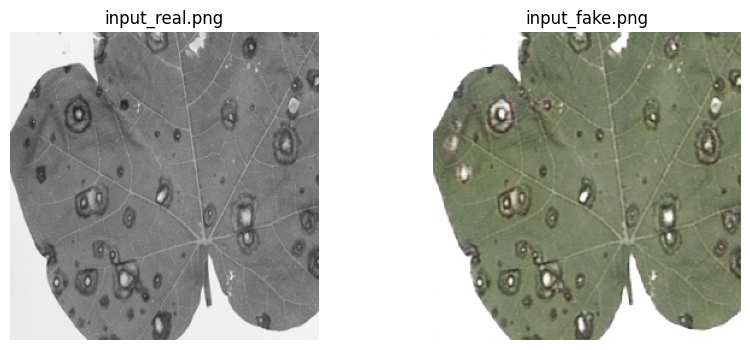

In [199]:
from PIL import Image as PILImage # Re-import local para evitar conflitos

img_dir = Path("/content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images")

fake = next((p for p in img_dir.glob("*") if "fake" in p.name.lower()), None)
real = next((p for p in img_dir.glob("*") if "real" in p.name.lower()), None)

print("Arquivo real:", real)
print("Arquivo fake:", fake)

paths = [p for p in [real, fake] if p is not None]

plt.figure(figsize=(10, 4))
for i, p in enumerate(paths, 1):
    plt.subplot(1, len(paths), i)
    plt.imshow(PILImage.open(p)) # Usando PILImage.open() aqui
    plt.axis("off")
    plt.title(p.name)
plt.show()

Confirmar visualmente que o modelo gerou as imagens de reconstrução esperadas, mostrando a imagem de entrada (real_A) e a imagem colorida reconstruída (fake_B) lado a lado.

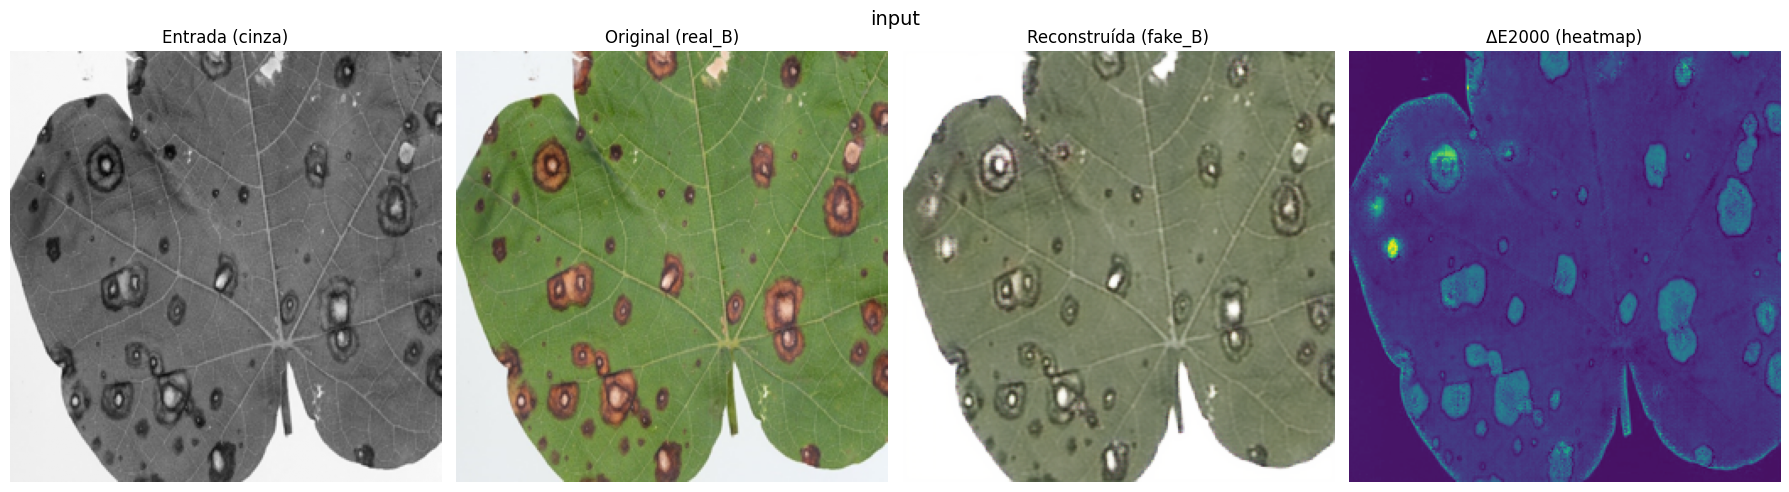

Entrada: /content/inferencia_single/single_in/input.jpg
Original: /content/inferencia_single/orig.jpg
Reconstruída: /content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images/input_fake.png
ΔE2000 média: 10.923959732055664


In [200]:
from PIL import Image, ImageOps

orig_path = Path("/content/inferencia_single/orig.jpg")
gray_path = Path("/content/inferencia_single/single_in/input.jpg")

img_dir = Path("/content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images")
assert img_dir.exists(), f"Pasta de imagens não existe: {img_dir}"

fake_path = next((p for p in sorted(img_dir.glob("*")) if "fake" in p.name.lower()), None)
assert fake_path is not None, f"Não encontrei arquivo fake em: {img_dir}"

orig = Image.open(orig_path).convert("RGB")
gray = Image.open(gray_path).convert("RGB")
fake = Image.open(fake_path).convert("RGB")

W, H = fake.size
orig_rs = orig.resize((W, H))
gray_rs = gray.resize((W, H))

real_np = np.asarray(orig_rs, dtype=np.float32) / 255.0
fake_np = np.asarray(fake,    dtype=np.float32) / 255.0

de = deltaE_ciede2000(rgb2lab(real_np), rgb2lab(fake_np))

title_id = fake_path.stem.replace("_fake", "").replace("_fake_B", "").replace("_fake_A", "")

plt.figure(figsize=(18, 5))
plt.suptitle(title_id, fontsize=14)

plt.subplot(1, 4, 1)
plt.imshow(np.asarray(gray_rs.convert("L")), cmap="gray")
plt.title("Entrada (cinza)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(orig_rs)
plt.title("Original (real_B)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(fake)
plt.title("Reconstruída (fake_B)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(de)
plt.title("ΔE2000 (heatmap)")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Entrada:", gray_path)
print("Original:", orig_path)
print("Reconstruída:", fake_path)
print("ΔE2000 média:", float(de.mean()))

Análise visual e quantitativa aprofundada de um único caso de reconstrução de cor, utilizando a imagem original, a imagem de entrada em escala de cinza e a imagem colorida reconstruída pelo modelo.

In [201]:
from PIL import Image as PILImage # Re-import local para evitar conflitos

def load_rgb(p: Path) -> np.ndarray:
    """Carrega imagem RGB como numpy uint8 (H, W, 3)."""
    return np.asarray(PILImage.open(p).convert("RGB"))

def resize_to(img: np.ndarray, target_hw: tuple[int, int]) -> np.ndarray:
    """Redimensiona img para (H, W) do target."""
    return np.asarray(PILImage.fromarray(img).resize((W, H)))

In [202]:
def leaf_mask_from_rgb(rgb: np.ndarray, white_thr: int = 240) -> np.ndarray:
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    mask = (r < white_thr) | (g < white_thr) | (b < white_thr)
    return mask

def de2000_map(real_rgb_u8: np.ndarray, fake_rgb_u8: np.ndarray) -> np.ndarray:
    real = real_rgb_u8.astype(np.float32) / 255.0
    fake = fake_rgb_u8.astype(np.float32) / 255.0
    return deltaE_ciede2000(rgb2lab(real), rgb2lab(fake))

def metric_top_p_mean(de_map: np.ndarray, leaf_mask: np.ndarray, top_p: float = 0.02) -> float:
    vals = de_map[leaf_mask]
    if vals.size == 0:
        return 0.0
    k = max(1, int(np.ceil(top_p * vals.size)))
    topk = np.partition(vals, -k)[-k:]
    return float(topk.mean())

def metric_concentration_top_q_energy(de_map: np.ndarray, leaf_mask: np.ndarray, top_q: float = 0.01) -> float:
    vals = de_map[leaf_mask]
    if vals.size == 0:
        return 0.0
    k = max(1, int(np.ceil(top_q * vals.size)))
    topk = np.partition(vals, -k)[-k:]
    denom = float(vals.sum()) + 1e-12
    return float(topk.sum() / denom)



In [212]:
def calculate_hsl_error_pixelwise(img_real, img_fake, mask=None):
    """
    Calcula erro de cor no espaço HSV (melhor que HLS para plantas).

    Foco:
    - H (Hue): Mudança de cor (verde -> amarelo/marrom = doença)
    - S (Saturation): Perda de saturação (planta murcha)
    - V (Value): Escurecimento (necrose)

    Returns:
        float: Score de erro normalizado [0, 1]
               Valores altos = maior anomalia
    """
    # Converter RGB para HSV (melhor para vegetação)
    real_hsv = cv2.cvtColor(img_real, cv2.COLOR_RGB2HSV).astype(np.float32)
    fake_hsv = cv2.cvtColor(img_fake, cv2.COLOR_RGB2HSV).astype(np.float32)

    # Separar canais
    h_real, s_real, v_real = cv2.split(real_hsv)
    h_fake, s_fake, v_fake = cv2.split(fake_hsv)

    # === TRATAMENTO ESPECIAL DO HUE (circular) ===
    # Hue varia de 0-180 no OpenCV, é circular
    diff_h = np.abs(h_real - h_fake)
    diff_h = np.minimum(diff_h, 180 - diff_h)  # Distância circular

    # === DIFERENÇAS LINEARES ===
    diff_s = np.abs(s_real - s_fake)
    diff_v = np.abs(v_real - v_fake)

    # === APLICAR MÁSCARA ===
    if mask is not None:
        mask_bin = (mask > 0).astype(np.float32)
        diff_h *= mask_bin
        diff_s *= mask_bin
        diff_v *= mask_bin
        num_pixels = np.sum(mask_bin)
    else:
        num_pixels = img_real.shape[0] * img_real.shape[1]

    if num_pixels == 0:
        return 0.0

    # === CÁLCULO DE SCORE PONDERADO ===
    # Pesos baseados em importância para detecção de doenças:
    # - Hue: mais importante (mudança de verde para amarelo/marrom)
    # - Saturation: média importância (perda de vivacidade)
    # - Value: menor importância (pode variar com iluminação)

    weight_h = 0.5
    weight_s = 0.35
    weight_v = 0.15

    # Normalizar cada componente para [0, 1]
    score_h = np.sum(diff_h) / (num_pixels * 90.0)   # Hue máx = 90 (metade de 180)
    score_s = np.sum(diff_s) / (num_pixels * 255.0)  # Saturation máx = 255
    score_v = np.sum(diff_v) / (num_pixels * 255.0)  # Value máx = 255

    # Score final ponderado
    total_score = (weight_h * score_h +
                   weight_s * score_s +
                   weight_v * score_v)

    return total_score

Arquivo fake: input_fake.png
Métrica 1, detecção por imagem, Top2% mean ΔE2000: 32.42387390136719
Métrica 2, proxy de localização, Top1% energy fraction: 0.033418744802474976
Métrica 3, HSL error analysis: 0.17793


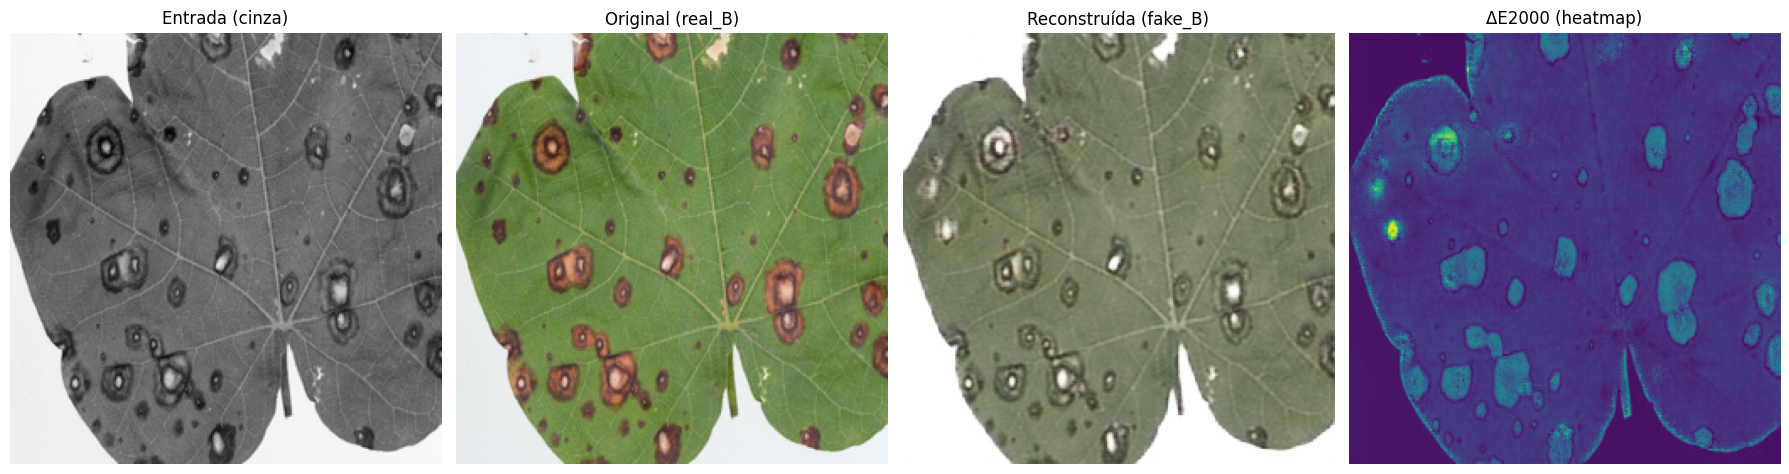

In [214]:
from PIL import Image as PILImage # Re-import local para evitar conflitos

base = Path("/content/inferencia_single")
orig_path = base / "orig.jpg"
gray_path = base / "single_in" / "input.jpg"

img_dir = base / "results" / "ramularia_colorrec_pix2pix" / "test_latest" / "images"
fake_path = next((p for p in sorted(img_dir.glob("*")) if "fake" in p.name.lower()), None)
if fake_path is None:
    raise FileNotFoundError(f"Não encontrei arquivo fake em {img_dir}")

orig = load_rgb(orig_path)
gray = load_rgb(gray_path)
fake = load_rgb(fake_path)

H, W = fake.shape[:2]
orig_rs = resize_to(orig, (H, W))
gray_rs = resize_to(gray, (H, W))

# Gera a máscara
leaf_mask = leaf_mask_from_rgb(orig_rs, white_thr=240)

# Métricas originais
de = de2000_map(orig_rs, fake)
score_detect = metric_top_p_mean(de, leaf_mask, top_p=0.02)
score_loc = metric_concentration_top_q_energy(de, leaf_mask, top_q=0.01)

# --- NOVO: Métrica HSL ---
score_hsl = calculate_hsl_error_pixelwise(orig_rs, fake, leaf_mask.astype(np.uint8))

print("Arquivo fake:", fake_path.name)
print("Métrica 1, detecção por imagem, Top2% mean ΔE2000:", score_detect)
print("Métrica 2, proxy de localização, Top1% energy fraction:", score_loc)
print("Métrica 3, HSL error analysis:", score_hsl)

# Plotagem (permanece igual)
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(np.asarray(PILImage.fromarray(gray_rs).convert("L")), cmap="gray")
plt.title("Entrada (cinza)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(orig_rs)
plt.title("Original (real_B)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(fake)
plt.title("Reconstruída (fake_B)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(de)
plt.title("ΔE2000 (heatmap)")
plt.axis("off")

plt.tight_layout()
plt.show()

## 5. Detecção de anomalia


=== RESULTADOS PARA: input_fake.png ===
------------------------------
Métricas Calculadas: {'Ciede2000_sum_mask': np.float32(713642.94), 'Top2pct_mean_deltaE2000': 32.42, 'Top1pct_energy_fraction': 0.0334, 'Hist_similarity_rgb': 15147.0, 'Hist_hsl': np.float32(0.18)}
------------------------------
CLASSIFICAÇÃO A (Baseado em CIEDE2000 > 350000):
Resultado: DOENTE
Métricas usadas: ['Ciede2000_sum_mask', 'Top2pct_mean_deltaE2000', 'Top1pct_energy_fraction', 'Hist_similarity_rgb']
------------------------------
CLASSIFICAÇÃO B (Baseado em HSL < 0.65):
Resultado: SAUDÁVEL
Métricas usadas: ['Ciede2000_sum_mask', 'Top2pct', 'Top1pct', 'Hist_hsl']
------------------------------


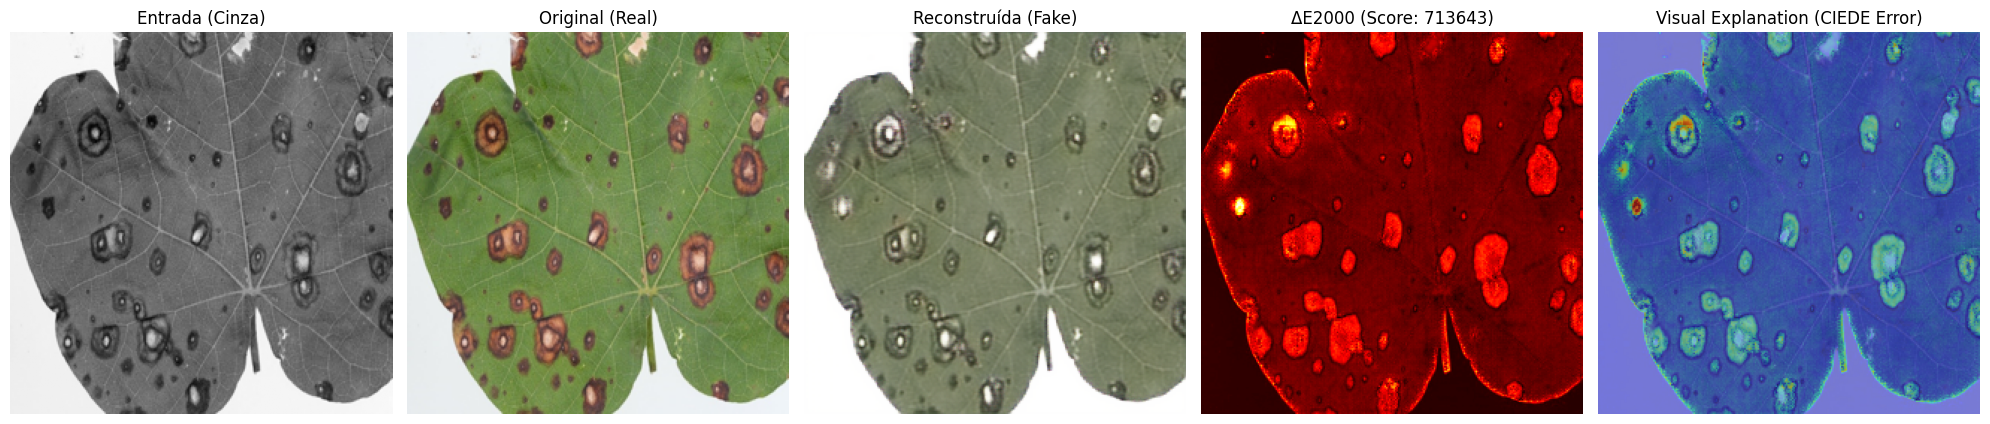

In [217]:
base = Path("/content/inferencia_single")
orig_path = base / "orig.jpg"
gray_path = base / "single_in" / "input.jpg"

# Busca arquivo fake
img_dir = base / "results" / "ramularia_colorrec_pix2pix" / "test_latest" / "images"
fake_path = next((p for p in sorted(img_dir.glob("*")) if "fake" in p.name.lower()), None)
if fake_path is None:
    raise FileNotFoundError(f"Não encontrei arquivo fake em {img_dir}")

orig = load_rgb(orig_path)
gray = load_rgb(gray_path)
fake = load_rgb(fake_path)

H, W = fake.shape[:2]
orig_rs = resize_to(orig, (H, W))
gray_rs = resize_to(gray, (H, W))

# --- 2. Cálculo de Todas as Métricas ---
leaf_mask = leaf_mask_from_rgb(orig_rs, white_thr=240)

# Métrica Base (CIEDE2000)
de = de2000_map(orig_rs, fake)
ciede_sum = np.sum(de[leaf_mask > 0]) # Soma na máscara
score_detect = metric_top_p_mean(de, leaf_mask, top_p=0.02)
score_loc = metric_concentration_top_q_energy(de, leaf_mask, top_q=0.01)

# Métrica Histograma RGB (Exemplo simples de intersecção)
hist_sim_rgb = cv2.compareHist(
    cv2.calcHist([orig_rs], [0, 1, 2], leaf_mask.astype(np.uint8), [8, 8, 8], [0, 256]*3),
    cv2.calcHist([fake], [0, 1, 2], leaf_mask.astype(np.uint8), [8, 8, 8], [0, 256]*3),
    cv2.HISTCMP_INTERSECT
)

# Métrica Nova (HSL)
score_hsl = calculate_hsl_error_pixelwise(orig_rs, fake, leaf_mask.astype(np.uint8))

# --- 3. Lógica de Diagnóstico Comparativo ---

# Diagnóstico A: Baseado puramente na anomalia de cor (Artigo Katafuchi)
# Se o erro de cor for alto -> Doente
diag_A = "DOENTE" if ciede_sum > THRESHOLD_CIEDE else "SAUDÁVEL"

# Diagnóstico B: Baseado na Similaridade HSL (Contraste)
# Se a similaridade for baixa -> Doente
diag_B = "DOENTE" if score_hsl > THRESHOLD_HSL else "SAUDÁVEL"

# Montando os dicionários de resposta
metrics_full = {
    "Ciede2000_sum_mask": round(ciede_sum, 2),
    "Top2pct_mean_deltaE2000": round(score_detect, 2),
    "Top1pct_energy_fraction": round(score_loc, 4),
    "Hist_similarity_rgb": round(hist_sim_rgb, 2),
    "Hist_hsl": round(score_hsl, 2)
}

print(f"\n=== RESULTADOS PARA: {fake_path.name} ===")
print("-" * 30)
print(f"Métricas Calculadas: {metrics_full}")
print("-" * 30)
print(f"CLASSIFICAÇÃO A (Baseado em CIEDE2000 > {THRESHOLD_CIEDE}):")
print(f"Resultado: {diag_A}")
print(f"Métricas usadas: {list(metrics_full.keys())[:4]}")
print("-" * 30)
print(f"CLASSIFICAÇÃO B (Baseado em HSL < {THRESHOLD_HSL}):")
print(f"Resultado: {diag_B}")
print(f"Métricas usadas: {['Ciede2000_sum_mask', 'Top2pct', 'Top1pct', 'Hist_hsl']}")
print("-" * 30)

# --- 4. Visualização com Grad-CAM ---

# Gerar Grad-CAM (Necessita do modelo classificador auxiliar carregado como 'net_classifier')
# Se não tiver treinado, use um placeholder ou o mapa de erro CIEDE como proxy visual
try:
    # Supondo que você tem a função generate_gradcam definida anteriormente
    # e um modelo classificador carregado
    input_tensor = transforms.ToTensor()(PILImage.fromarray(orig_rs)).unsqueeze(0).to(device)
    gradcam_map = generate_gradcam(net_classifier, input_tensor, class_idx=1) # 1 = Doente
    gradcam_title = "Grad-CAM (ResNet)"
except NameError:
    # Fallback se não tiver classificador: Usar mapa de erro como "Visual Explanation"
    gradcam_map = de
    gradcam_title = "Visual Explanation (CIEDE Error)"

# Plotagem Ajustada (5 colunas agora)
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.imshow(np.asarray(PILImage.fromarray(gray_rs).convert("L")), cmap="gray")
plt.title("Entrada (Cinza)")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(orig_rs)
plt.title("Original (Real)")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(fake)
plt.title("Reconstruída (Fake)")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(de, cmap='hot') # Mapa de calor quente fica melhor para erro
plt.title(f"ΔE2000 (Score: {ciede_sum:.0f})")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(orig_rs)
plt.imshow(gradcam_map, cmap='jet', alpha=0.5)
plt.title(gradcam_title)
plt.axis("off")

plt.tight_layout()
plt.show()

## Visualização final usando Grad-CAM

Referência https://keras.io/examples/vision/grad_cam/

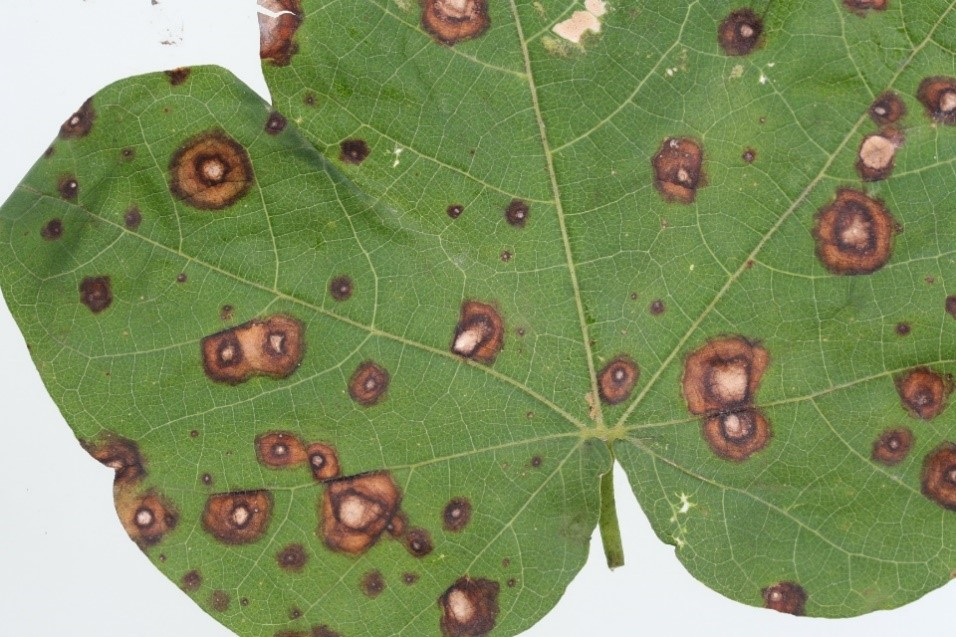

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [('n12267677', 'acorn', np.float32(6.259379))]


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1072']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


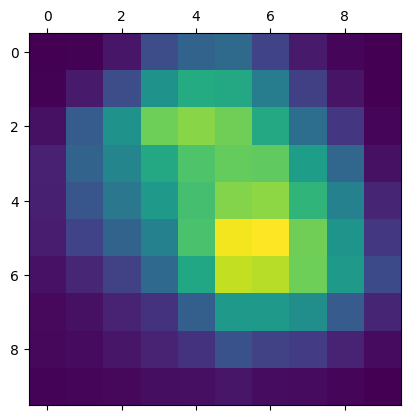

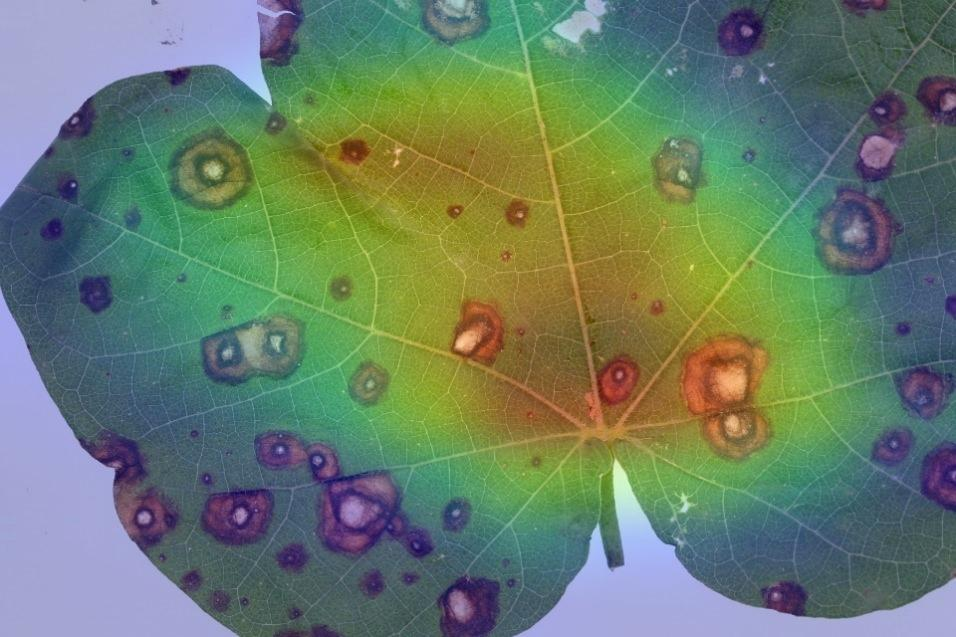

In [218]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

# --------------------------------- #
# configurando os parâmetros
# --------------------------------- #
model_builder = keras.applications.xception.Xception
img_size = (299, 299) # Ajustado para corresponder às dimensões esperadas pelo modelo Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
# Corrected: Directly use the local path as the image is already downloaded
img_path = "/content/inferencia_single/orig.jpg"

display(Image(img_path))

# --------------------------------- #
# Código do algoritmo Grad-CAM
# --------------------------------- #

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --------------------------------- #
# Testando o algoritmo Grad-CAM
# --------------------------------- #

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# --------------------------------- #
# Criando visualização do heatmap sobre a imagem
# --------------------------------- #

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)